STL + ARIMA + ES + LSTM


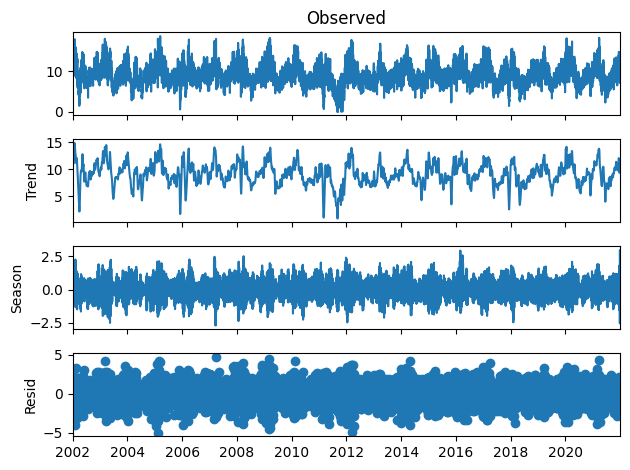

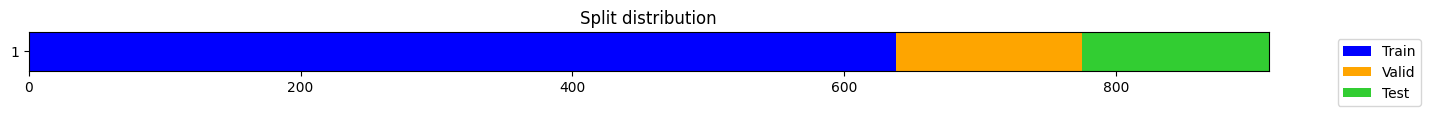

Epoch 23: reducing lr to 0.00012574664792260306
Epoch 37: reducing lr to 3.761007139515327e-05
Epoch 40: reducing lr to 2.210472201096955e-05
Epoch 48: reducing lr to 3.4650006015431425e-07
Métricas de Treinamento para <class 'tsai.models.RNNPlus.LSTMPlus'>


train_loss    0.418704
valid_loss    0.395391
mae           0.754215
_rmse         0.977355
dtype: float64

Performing stepwise search to minimize bic
 ARIMA(4,1,0)(0,0,0)[0] intercept   : BIC=-25486.157, Time=2.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=-2571.084, Time=0.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=-15977.903, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=-10447.701, Time=1.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=-2579.815, Time=0.28 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : BIC=-24055.694, Time=1.03 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : BIC=-25480.367, Time=2.95 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : BIC=-25479.813, Time=8.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : BIC=-25075.112, Time=6.45 sec


KeyboardInterrupt: 

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import AutoARIMA
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tsai.all import *
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
import optuna
import seaborn as sns
from scipy.stats import shapiro, kstest, jarque_bera
from statsmodels.stats.stattools import durbin_watson
from sfrancia import shapiroFrancia
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
import scipy.stats as stats
from matplotlib.gridspec import GridSpec
import scipy.stats as stats


class optuna_optimize:
    def __init__(self,arch,X,y,splits,epochs):
        self.arch = arch
        self.X = X
        self.y = y
        self.splits = splits
        self.epochs = epochs

    def optuna_objective(self,trial):
        hidden_size = trial.suggest_int('hidden_size', 16, 200)
        n_layers = trial.suggest_int('n_layers', 1, 5)
        rnn_dropout = trial.suggest_float('rnn_dropout', 0, 0.8)
        bidirectional = trial.suggest_categorical('bidirectional', [True, False])
        fc_dropout = trial.suggest_float('fc_dropout', 0, 0.8)
        learning_rate_model = trial.suggest_float('learning_rate_model', 1e-5, 1e-1,log=True)

        arch_config ={
            'hidden_size': hidden_size,
            'n_layers': n_layers,
            'rnn_dropout': rnn_dropout,
            'bidirectional': bidirectional,
            'fc_dropout': fc_dropout
        }
        tfms = [None, TSForecasting()]
        learn = TSForecaster(self.X, self.y, splits=self.splits, path='models', tfms=tfms,
                            batch_tfms=TSStandardize(),
                            arch=self.arch, arch_config=arch_config, metrics=[rmse],
                            cbs=[
                                ReduceLROnPlateau(patience=3)
                            ],seed=1)
        
        with ContextManagers([learn.no_bar(),learn.no_logging()]):
            learn.fit_one_cycle(self.epochs, lr_max=learning_rate_model)
            raw_preds, target, _ = learn.get_X_preds(self.X[self.splits[1]], self.y[self.splits[1]])
            intermediate_value = mean_squared_error(y_true=target, y_pred=raw_preds, squared=False)
        
        return intermediate_value



def forecast_arima(series, new_data, seasonal=False, m=1, arima_model=None,
                    start_p=4, start_q=0, d=None, max_p=10, max_q=10, max_d=3, max_order=None,
                    start_P=1, start_Q=1, D=None, max_P=8, max_Q=8, max_D=1):
    
    if not arima_model:
        arima_model = AutoARIMA(start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_d=max_d,
                                max_q=max_q, max_order=max_order, start_P=start_P, D=D, start_Q=start_Q,
                                max_P=max_P, max_D=max_D, max_Q=max_Q, seasonal=seasonal, m=m,
                                trace=True, error_action='ignore', suppress_warnings=True,
                                stepwise=True, information_criterion='bic', scoring='mse',
                                with_intercept='auto')
        
    arima_model = arima_model.fit(y=series)
    lista_previsoes = []
    for j in range(new_data.shape[0]):
        janela_8_dias = new_data[j, 0]
        previsao = arima_model.predict(n_periods=8)
        lista_previsoes.append(previsao)
        arima_model = arima_model.update(janela_8_dias)

    forecast = np.array(lista_previsoes)
    return arima_model, forecast

def forecast_exponential_smoothing(series, new_data, trend='add', seasonal='add', seasonal_periods=7,
                                    initialization_method='heuristic', use_boxcox=False):
    model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods,
                                    initialization_method=initialization_method, use_boxcox=use_boxcox)
    model_fit = model.fit()

    lista_previsoes = []
    for j in range(new_data.shape[0]):
        previsao = model_fit.forecast(steps=8)
        lista_previsoes.append(previsao)
        series = np.concatenate([series, new_data[j, 0]])
        model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods,
                                        initialization_method=initialization_method)
        model_fit = model.fit()

    forecast = np.array(lista_previsoes)
    return model_fit, forecast

def forecast_ann(X, y,splits,model = LSTMPlus, epochs=100,arch_config={},btfms=TSStandardize(),loss_func=nn.MSELoss(),cbs=[],lr = None):
    learn = TSForecaster(X, y,splits=splits, arch=model, metrics=[mae, rmse],arch_config=arch_config, batch_tfms=btfms, tfms=[None, [TSForecasting()]], loss_func=loss_func) # type: ignore
    with ContextManagers([learn.no_logging(), learn.no_bar()]):
        if not lr:
            lr = learn.lr_find() # Achar o melhor learning rate pro modelo, método da biblioteca fastai
            learn.fit_one_cycle(epochs, lr_max=lr.valley, cbs=cbs) # Treinar o modelo
        else:
            learn.fit_one_cycle(epochs, lr_max=lr, cbs=cbs)
        print(f'Métricas de Treinamento para {model}')
        display(pd.Series(learn.recorder.values[-1], index=learn.recorder.metric_names[1:5]))
        raw_preds, target, _ = learn.get_X_preds(X[splits[2]],y[splits[2]])
        return raw_preds,target



def decompose_series(series):
    decomposed = STL(series).fit()
    trend = decomposed.trend
    seasonal = decomposed.seasonal
    resid = decomposed.resid
    decomposed.plot()
    return trend, seasonal, resid


def load_and_prepare_data(filepath):
    peru = pd.read_csv(filepath, index_col='index').rename(columns={'GPP': 'peru'})
    peru.index = pd.to_datetime(peru.index)
    peru = peru.resample('D').mean()
    return peru


def plot_boxplot(forecast1, forecast2, target1, target2, dt_index):
    preds_residuals1 = forecast1 - target1
    preds_residuals2 = forecast2 - target2

    df_residuos = pd.DataFrame({
        'Resíduos STL-ARIMA-ES-LSTM': preds_residuals1,
        'Resíduos LSTM': preds_residuals2
    }, index=dt_index)
    df_residuos.to_csv('residuos.csv')

    df_residuos_monthly = df_residuos.resample('M').mean()
    df_residuos_monthly.reset_index(inplace=True)

    df_residuos_melted = df_residuos_monthly.melt(id_vars='index', var_name='Modelo', value_name='Resíduos')
    df_residuos_melted['Ano'] = df_residuos_melted['index'].dt.year
    df_residuos_melted['Mes'] = df_residuos_melted['index'].dt.strftime('%b')

    fig, ax = plt.subplots(figsize=(14, 8))
    sns.boxplot(data=df_residuos_melted, x='Mes', y='Resíduos', hue='Modelo', dodge=True, ax=ax, width=0.4)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, label=None)
    ax.set_title('Box Plot Mensal de Resíduos (g)')
    ax.set_ylabel('Resíduos')
    ax.set_xlabel('Mês')
    ax.legend(loc='lower center', fontsize=12, ncol=2)

    plt.tight_layout()
    plt.savefig('boxplot.png')
    plt.show()


def acf(forecast1, forecast2, target1, target2):
    preds_residuals1 = forecast1 - target1
    preds_residuals2 = forecast2 - target2

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    def plot_acf_custom(ax, residuals, title):
        sm.graphics.tsa.plot_acf(residuals, ax=ax)
        ax.set_title(title)

    plot_acf_custom(axs[0], preds_residuals1, 'Autocorrelação dos Resíduos (STL-ARIMA-ES-LSTM) (e)')
    plot_acf_custom(axs[1], preds_residuals2, 'Autocorrelação dos Resíduos (LSTM) (f)')

    plt.tight_layout()
    plt.savefig('acf.png')
    plt.show()

def plot_qq_hist_kde(forecast1, forecast2, target1, target2):
    preds_residuals1 = forecast1 - target1
    preds_residuals2 = forecast2 - target2

    fig, axs = plt.subplots(2, 2, figsize=(13, 9))

    def plot_qq(ax, residuals, title):
        residuals = stats.zscore(residuals)
        sm.qqplot(residuals, line='s', ax=ax)
        ax.set_title(title)

    plot_qq(axs[0, 0], preds_residuals1, 'Q-Q Plot dos Resíduos (STL-ARIMA-ES-LSTM) (a)')
    plot_qq(axs[0, 1], preds_residuals2, 'Q-Q Plot dos Resíduos (LSTM) (b)')

    def plot_hist(ax, residuals, title):
        residuals_norm = stats.zscore(residuals)
        sns.histplot(x=residuals_norm, kde=True, ax=ax, stat='density', linewidth=0, bins=20)
        x_min, x_max = ax.get_xlim()
        x_axis = np.linspace(x_min, x_max, 100)
        normal_curve = stats.norm.pdf(x_axis, np.mean(residuals_norm), np.std(residuals_norm))
        ax.plot(x_axis, normal_curve, color='red', linestyle='--', linewidth=2, label='Distribuição Normal')
        ax.set_title(title)
        ax.legend()

    plot_hist(axs[1, 0], preds_residuals1, 'Histograma com KDE dos Resíduos Normalizados (STL-ARIMA-ES-LSTM) (c)')
    plot_hist(axs[1, 1], preds_residuals2, 'Histograma com KDE dos Resíduos Normalizados (LSTM) (d)')

    plt.tight_layout()
    plt.savefig('qq_hist_kde.png')
    plt.show()
    


    print('Resumo dos resíduos do modelo STL-ARIMA-ES-LSTM:')
    hyp_tests(preds_residuals1)
    print('====================================================================================================')
    print('Resumo dos resíduos do modelo LSTM:')
    hyp_tests(preds_residuals2)

def residual_general_summary(forecast1, forecast2, target1, target2, dt_index):
    sns.set_style('darkgrid')
    plot_qq_hist_kde(forecast1, forecast2, target1, target2)
    acf(forecast1, forecast2, target1, target2)
    plot_boxplot(forecast1, forecast2, target1, target2, dt_index)



def residual_summary(forecast, target, dt_index):
    sns.set_style('darkgrid')
    preds_residuals = forecast - target
    residuos = pd.Series(data=preds_residuals, index=dt_index)
    display(residuos)
    print(residuos.describe())

    # Configuração do layout dos subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))

    # Gráfico dos resíduos versus valores ajustados
    axes[0, 0].scatter(forecast, preds_residuals)
    axes[0, 0].axhline(0, color='red', linestyle='--')
    axes[0, 0].set_title('Resíduos vs Valores Ajustados')

    # Q-Q plot dos resíduos para verificar normalidade
    sm.qqplot(preds_residuals, line='s', ax=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot dos Resíduos')

    # Histograma dos resíduos
    sns.histplot(x=preds_residuals, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Histograma com KDE dos Resíduos')

    # Gráfico de autocorrelação dos resíduos
    plot_acf(preds_residuals, ax=axes[1, 1])
    axes[1, 1].set_title('Autocorrelação dos Resíduos')

    # Resíduos vs. Tempo
    axes[2, 0].plot(preds_residuals)
    axes[2, 0].axhline(0, color='red', linestyle='--')
    axes[2, 0].set_title('Resíduos ao longo do Tempo')

    # Remover o último subplot vazio
    sns.boxplot(x=preds_residuals, ax=axes[2, 1])
    axes[2, 1].set_title('Boxplot dos Resíduos')

    plt.tight_layout()
    plt.show()

def hyp_tests(residuos):
    shap = shapiro(residuos)
    shapiro_pvalue = shap[1]
    if shapiro_pvalue > 0.05:
        shapiro_interpretation = "Não podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal (p > 0.05)."
    else:
        shapiro_interpretation = "Rejeitamos a hipótese nula de que os resíduos seguem uma distribuição normal (p <= 0.05)."

    kstest_pvalue = kstest(residuos, 'norm')[1]
    if kstest_pvalue > 0.05:
        kstest_interpretation = "Não podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal (p > 0.05)."
    else:
        kstest_interpretation = "Rejeitamos a hipótese nula de que os resíduos seguem uma distribuição normal (p <= 0.05)."

    durbin_watson_stat = durbin_watson(residuos)
    if durbin_watson_stat < 1.5 or durbin_watson_stat > 2.5:
        durbin_watson_interpretation = "Possível autocorrelação nos resíduos (Durbin-Watson fora do intervalo 1.5-2.5)."
    else:
        durbin_watson_interpretation = "Não há evidência de autocorrelação nos resíduos (Durbin-Watson dentro do intervalo 1.5-2.5)."

    shapiro_francia_pvalue = shapiroFrancia(residuos)['p-value']
    if shapiro_francia_pvalue > 0.05:
        shapiro_francia_interpretation = "Não podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal (p > 0.05)."
    else:
        shapiro_francia_interpretation = "Rejeitamos a hipótese nula de que os resíduos seguem uma distribuição normal (p <= 0.05)."

    # Teste Ljung-Box para autocorrelação residual
    lb_pvalue = acorr_ljungbox(residuos)
    if np.any(lb_pvalue.values < 0.05):
        lb_interpretation = "Evidência significativa de autocorrelação nos resíduos."
    else:
        lb_interpretation = "Não há evidência significativa de autocorrelação nos resíduos."

    # Teste Jarque-Bera para normalidade dos resíduos
    jb_pvalue = jarque_bera(residuos)
    if jb_pvalue.pvalue < 0.05:
        jb_interpretation = "Os resíduos não seguem uma distribuição normal."
    else:
        jb_interpretation = "Os resíduos seguem uma distribuição normal."

    # Teste ARCH para heterocedasticidade condicional
    model_arch = arch_model(residuos)
    result = model_arch.fit(disp='off')
    arch_lm_test = result.arch_lm_test()
    arch_lm_pvalue = arch_lm_test.pval
    if arch_lm_pvalue < 0.05:
        arch_lm_interpretation = "Há evidência de heterocedasticidade condicional nos resíduos."
    else:
        arch_lm_interpretation = "Não há evidência de heterocedasticidade condicional nos resíduos."

    print("\nResumo das análises estatísticas:")
    print("Shapiro-Wilk Test p-value:", shapiro_pvalue, "-", shapiro_interpretation)
    print("Kolmogorov-Smirnov Test p-value:", kstest_pvalue, "-", kstest_interpretation)
    print("Durbin-Watson Statistic:", durbin_watson_stat, "-", durbin_watson_interpretation)
    print("Shapiro-Francia Test p-value:", shapiro_francia_pvalue, "-", shapiro_francia_interpretation)
    print("Ljung-Box Test p-value:", lb_pvalue, "-", lb_interpretation)
    print("Jarque-Bera Test p-value:", jb_pvalue.pvalue, "-", jb_interpretation)
    print("ARCH LM Test p-value:", arch_lm_pvalue, "-", arch_lm_interpretation)

def Default_LSTM(peru):
    peru_x,peru_y = SlidingWindow(window_len=8,horizon=8,stride=None)(peru['peru'].values)
    splits = TSSplitter(valid_size=0.15,test_size=0.15)(peru_y)

    #optuna_opt = optuna_optimize(LSTMPlus,peru_x,peru_y,splits,200)
    # study = run_optuna_study(optuna_opt.optuna_objective,sampler= optuna.samplers.TPESampler(n_startup_trials=250,seed=1),n_trials=500,gc_after_trial=True,direction="minimize",show_plots=False)
    # print(f"O Melhor modelo foi o de número {study.best_trial.number}")
    # print("Best hyperparameters: ", study.best_trial.params)

    parametros = {'hidden_size': 181, 'n_layers': 2, 'rnn_dropout': 0.13940812754731557, 'bidirectional': True, 'fc_dropout': 0.2910007691487212}
    lr = 0.000319603937235865

    peru_forecast, target_peru = forecast_ann(peru_x, peru_y, splits, model=LSTMPlus, epochs=200,
                                                     arch_config=parametros,
                                                     btfms=TSStandardize(),loss_func=HuberLoss('mean'),cbs=[ReduceLROnPlateau(patience=3)],
                                                     lr=lr)

    print(f"RMSE: {mean_squared_error(target_peru.flatten(), peru_forecast.flatten(), squared=False)}")
    print(f"MAE: {mean_absolute_error(target_peru.flatten(), peru_forecast.flatten())}")
    print(f"R²: {r2_score(target_peru.flatten(), peru_forecast.flatten())}")
    print(f"MAPE: {mean_absolute_percentage_error(target_peru.flatten(), peru_forecast.flatten())}")
    print(f"Correlação Linear: {np.corrcoef(target_peru.flatten(), peru_forecast.flatten())[0, 1]}")

    plt.figure(figsize=(20, 5))
    plt.plot(target_peru.flatten())
    plt.plot(peru_forecast.flatten())
    plt.show()

    residual_summary(peru_forecast.flatten(), target_peru.flatten(), peru['peru'].loc[peru['peru'].isin(peru_y[splits[2]].flatten())].index)
    return peru_forecast.numpy().flatten(), target_peru.numpy().flatten(), peru['peru'].loc[peru['peru'].isin(peru_y[splits[2]].flatten())].index




def STL_ARIMA_ES_LSTM(peru):

    trend, seasonal, resid = decompose_series(peru)

    resid_x,resid_y = SlidingWindow(window_len=8,horizon=8,stride=None)(resid.values)
    splits_testando = TSSplitter(valid_size=0.15,test_size=0.15)(resid_y)

    # optuna_opt = optuna_optimize(LSTMPlus,resid_x,resid_y,splits_testando,epochs=50)
    # study = run_optuna_study(optuna_opt.optuna_objective,sampler= optuna.samplers.TPESampler(n_startup_trials=250,seed=1),n_trials=500,gc_after_trial=True,direction="minimize",show_plots=False)
    # print(f"O Melhor modelo foi o de número {study.best_trial.number}")
    # print("Best hyperparameters: ", study.best_trial.params)
    
    parametros = {'hidden_size': 171, 'n_layers': 2, 'rnn_dropout': 0.1258914379041145, 'bidirectional': True, 'fc_dropout': 0.6858054121901836}
    lr = 0.001593407261945087

    residual_forecast,target_residual = forecast_ann(resid_x, resid_y,splits_testando,model=LSTMPlus, epochs=50,
                                                     arch_config=parametros,
                                                     btfms=TSStandardize(),loss_func=HuberLoss('mean'),cbs=[ReduceLROnPlateau(patience=3)],
                                                     lr=lr)

    train_values = np.concatenate([resid_x[splits_testando[0]].flatten(),resid_x[splits_testando[1]].flatten()])
    train_index = resid.loc[resid.isin(train_values)].index
    test_index = resid.loc[resid.isin(resid_x[splits_testando[2]].flatten())].index

    train_trend = trend.loc[train_index]
    test_trend = trend.loc[test_index]

    arima_model, trend_forecast = forecast_arima(series=train_trend,new_data=test_trend.values.reshape(-1,1,8))

    train_seasonal = seasonal.loc[train_index]
    test_seasonal = seasonal.loc[test_index]
    es_model, seasonal_forecast = forecast_exponential_smoothing(series=train_seasonal,new_data=test_seasonal.values.reshape(-1,1,8),trend=None,seasonal_periods=7)

    final_pred = residual_forecast.flatten() + seasonal_forecast.flatten() + trend_forecast.flatten()
    real_values = target_residual.numpy().flatten() + test_trend + seasonal[test_trend.index]
    index = real_values.index
    real_values = real_values.values
    final_pred = final_pred.numpy()

    print(f"RMSE: {mean_squared_error(real_values, final_pred, squared=False)}")
    print(f"MAE: {mean_absolute_error(real_values, final_pred)}")
    print(f"R²: {r2_score(real_values, final_pred)}")
    print(f"MAPE: {mean_absolute_percentage_error(real_values, final_pred)}")
    print(f"Correlação Linear: {np.corrcoef(real_values, final_pred)[0, 1]}")

    plt.figure(figsize=(20, 5))
    plt.plot(index, real_values)
    plt.plot(index, final_pred)
    plt.show()

    residual_summary(final_pred, real_values, resid.loc[resid.isin(resid_x[splits_testando[2]].flatten())].index)
    return final_pred, real_values




def main():
    filepath = 'peru.csv'
    peru = load_and_prepare_data(filepath)
    print('====================================================================================================')
    print('STL + ARIMA + ES + LSTM')
    hybrid_forecast, target_hybrid = STL_ARIMA_ES_LSTM(peru=peru)
    print('====================================================================================================')
    print('Default LSTM')
    lstm_forecast, target_lstm, datetime = Default_LSTM(peru=peru)
    print('====================================================================================================')
    residual_general_summary(hybrid_forecast, lstm_forecast, target_hybrid, target_lstm, datetime)

#hybrid {'hidden_size': 163, 'n_layers': 2, 'rnn_dropout': 0.28543080719135755, 'bidirectional': True, 'fc_dropout': 0.5943357855320079, 'learning_rate_model': 0.001686988205506411}
#lstm {'hidden_size': 181, 'n_layers': 2, 'rnn_dropout': 0.13940812754731557, 'bidirectional': True, 'fc_dropout': 0.2910007691487212, 'learning_rate_model': 0.000319603937235865}



if __name__ == '__main__':
    main()